### Our approach: orthogonal greedy algorithm 

**OGA:**
\begin{equation} 
			f_0 = 0, \quad g_n  = \mathop{\arg \max}_{g \in \mathbb{D}}  | \langle g, f - f_{n-1}
			\rangle |, \quad f_n = P_n(f),  
		\end{equation}
		where $P_n$ is a projection onto $H_n = \text{span}\{g_1, g_2,...,g_n \}$
		 For 1D $L^2$-fitting for target $f(x)$ with $f(0) = 0$, the ReLU shallow neural network dictionary can be given by 
		\begin{equation}
			\mathbb{D} = \{ \sigma( x + b), b \in [0,1]  \}, ~~~ \sigma(x) = \max(0,x)
		\end{equation}
        


**Theretically guaranteed convergence rate:** 

Let the iterates $f_n$ be given by the orthogonal greedy algorithm, where $f\in \mathcal{V}_1(\mathbb{P}_k^d)$, where $\mathbb{P}_k^d$ is the $\text{ReLU}^k$ dictionary, $\sigma_k(\omega \cdot x + b)$,  $\sigma(x) = \max^k(0,x)$

Then we have
  \begin{equation}
   \|f_n - f\|_{L^2} \lesssim \|f\|_{\mathcal{V}_1(\mathbb{P}_k^d)}n^{-\frac{1}{2} - \frac{2k+1}{2d}}.
  \end{equation}
  
 **In particular**, for a ReLU shallow neural network in 1D, we have ($k=1, d=1$)
   \begin{equation}
   \|f_n - f\|_{L^2} \lesssim \|f\|_{\mathcal{V}_1(\mathbb{P}_1^1)}n^{-2}.
  \end{equation}
  

**Two major steps in OGA**:

1. argmax 
2. projection

**How to implement the two major steps in OGA?**

1. Solve the argmax problem
    - $L^2$ innner product: numerical integration 
        - Piecewise Gauss quadrature (very accurate numerical quadrature is needed for this part)
    - Method of exhaustion for 1D for a good initial guess 
        - $\mathbb{D}_N = \{ \sigma(x + b_i), -b_i = \frac{i-1}{N_1} \}_{i = 1}^N$
    
2. Orthogonal projection. Given $H_n = \text{span}\{g_1, g_2,...,g_n \}$
    - Some mathematics derivation here for the linear system
         - $<f_n,g_i> = <f,g_i>$ for all $i= 1,2,...,n$, with $f_n = \sum_{i=1}^n a_i g_i $
         - A linear system in $\alpha := (a_1, a_2,...,a_n)^T$. $M \alpha = b$, where $M_{i,j} = <g_j,g_i>$ $b_i = <f,g_i> $
         - Equivalently, an $L^2$-fitting: $\min_{a_1, a_2,...,a_n} \frac{1}{2} \|\sum_{i=1}^n a_i g_i  - f \|^2_{L^2} $, that is $\min_{\alpha \in \mathbb{R}^n} \frac{1}{2} \alpha^T M \alpha - b^T \alpha $
    - A shortcut: make use of pytorch automatic differentiation to get the matrix M, since we already know how to compute the loss function very accurately.



In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import sys
from scipy.sparse import linalg
from pathlib import Path
torch.set_default_dtype(torch.float64)
pi = torch.tensor(np.pi)
import matplotlib.pyplot as plt 

if torch.cuda.is_available():  
    device = "cuda" 
else:  
    device = "cpu"  

class model(nn.Module):
    """ ReLU k shallow neural network
    Parameters: 
    input size: input dimension
    hidden_size1 : number of hidden layers 
    num_classes: output classes 
    k: degree of relu functions
    """
    def __init__(self, input_size, hidden_size1, num_classes,k = 1):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, num_classes,bias = False)
        self.k = k 
    def forward(self, x):
        u1 = self.fc2(F.relu(self.fc1(x))**self.k)
        return u1
    

def plot_solution_modified(r1,r2,model,x_test,u_true,name=None): 
    # Plot function: test results 
    u_model_cpu = model(x_test).cpu().detach()
    
    w = model.fc1.weight.data.squeeze()
    b = model.fc1.bias.data.squeeze()
    x_model_pt = (-b/w).view(-1,1)
    u_model_pt = model(x_model_pt).cpu().detach()
    plt.figure(dpi = 100)
    plt.plot(x_test.cpu(),u_model_cpu,'-.',label = "nn function")
    plt.plot(x_test.cpu(),u_true.cpu(),label = "true")
    plt.plot(x_model_pt,u_model_pt,'.')
    if name!=None: 
        plt.title(name)
    plt.legend()
    plt.show()
    
def show_convergence_order(err_l2,exponent):
    
    neuron_nums = [2**j for j in range(2,exponent+1)]
    err_list = [err_l2[i] for i in neuron_nums ]

    print("neuron num \t\t error \t\t order")
    for i, item in enumerate(err_list):
        if i == 0: 
            print("{} \t\t {:.6f} \t\t *  \n".format(neuron_nums[i],item ) )

        else: 
            # print(neuron_nums[i], end = "\t\t")
            # print(item, end = "\t\t") 
            # print(np.log(err_list[i-1]/err_list[i])/np.log(2))
            print("{} \t\t {:.6f} \t\t {:.6f} \n".format(neuron_nums[i],item,np.log(err_list[i-1]/err_list[i])/np.log(2) ) )


def PiecewiseGQ1D_weights_points(x_l,x_r,Nx, order):
    """ Output the coeffients and weights for piecewise Gauss Quadrature 
    Parameters
    ----------
    x_l : float 
    left endpoint of an interval 
    
    x_r: float
    right endpoint of an interval 
    
    integration_intervals: int
    number of subintervals for integration
    
    Returns
    -------
    coef1_expand
    
    gw_expand
    
    integration_points
    """
    x,w = np.polynomial.legendre.leggauss(order)
    gx = torch.tensor(x).to(device)
    gx = gx.view(1,-1) # row vector 
    gw = torch.tensor(w).to(device)    
    gw = gw.view(-1,1) # Column vector 
    nodes = torch.linspace(x_l,x_r,Nx+1).view(-1,1).to(device) 
    coef1 = ((nodes[1:,:] - nodes[:-1,:])/2) # n by 1  
    coef2 = ((nodes[1:,:] + nodes[:-1,:])/2) # n by 1  
    coef2_expand = coef2.expand(-1,gx.size(1)) # Expand to n by p shape, -1: keep the first dimension n , expand the 2nd dim (columns)
    integration_points = coef1@gx + coef2_expand
    integration_points = integration_points.flatten().view(-1,1) # Make it a column vector
    gw_expand = torch.tile(gw,(Nx,1)) # rows: n copies of current tensor, columns: 1 copy, no change
    # Modify coef1 to be compatible with func_values
    coef1_expand = coef1.expand(coef1.size(0),gx.size(1))    
    coef1_expand = coef1_expand.flatten().view(-1,1)

    return coef1_expand.to(device) * gw_expand.to(device), integration_points.to(device)

def minimize_linear_layer_explicit_assemble(model,target,weights, integration_points,solver="direct"):
    """
    calls the following functions (dependency): 
    1. GQ_piecewise_2D
    input: the nn model containing parameter 
    1. define the loss function  
    2. take derivative to extract the linear system A
    3. call the cg solver in scipy to solve the linear system 
    output: sol. solution of Ax = b
    """
    start_time = time.time() 
    w = model.fc1.weight.data 
    b = model.fc1.bias.data 
    basis_value_col = F.relu(integration_points @ w.t()+ b)**(model.k) 
    weighted_basis_value_col = basis_value_col * weights 
    jac = weighted_basis_value_col.t() @ basis_value_col 
     
    rhs = weighted_basis_value_col.t() @ (target(integration_points)) 
#     print("assembling the matrix time taken: ", time.time()-start_time) 
    start_time = time.time()    
    if solver == "cg": 
        sol, exit_code = linalg.cg(np.array(jac.detach().cpu()),np.array(rhs.detach().cpu()),tol=1e-12)
        sol = torch.tensor(sol).view(1,-1)
    elif solver == "direct": 
#         sol = np.linalg.inv( np.array(jac.detach().cpu()) )@np.array(rhs.detach().cpu())
        sol = (torch.linalg.solve( jac.detach(), rhs.detach())).view(1,-1)
    elif solver == "ls":
        sol = (torch.linalg.lstsq(jac.detach().cpu(),rhs.detach().cpu(),driver='gelsd').solution).view(1,-1)
        # sol = (torch.linalg.lstsq(jac.detach(),rhs.detach()).solution).view(1,-1) # gpu/cpu, driver = 'gels', cannot solve singular
#     print("solving Ax = b time taken: ", time.time()-start_time)
    return sol 


In [2]:
# relu dictionary
def relu_dict(x_l,x_r,N):
    """generate relu dictionary parameters 
    
    Parameters
    ----------
    x_l: float 
    x_r: float
    N: int 
        number of degree of freedoms
        
    Returns
    torch tensor
        containing relu dictionary parameters, corresponds to nodal points
        
    """
    # w = 1 
    relu_dict_parameters = torch.zeros((2*N,2)).to(device)
    relu_dict_parameters[:N,0] = torch.ones(N)[:]
    relu_dict_parameters[:N,1] = torch.linspace(x_l,x_r,N+1)[:-1] # relu(x-bi)  
    relu_dict_parameters[N:2*N,0] = -torch.ones(N)[:]
    relu_dict_parameters[N:2*N,1] = -torch.linspace(x_l,x_r,N+1)[1:] + 1/(2*N) # relu(-x - -bi) 
    
    return relu_dict_parameters


def OGAL2FittingReLU1D(my_model,target,N,num_epochs,plot_freq = 10,Nx = 1024,order =5, k = 1, solver = 'direct'): 
    """ Orthogonal greedy algorithm using 1D ReLU dictionary over [-pi,pi]
    Parameters
    ----------
    my_model: 
        nn model 
    target: 
        target function
    num_epochs: int 
        number of training epochs 
    integration_intervals: int 
        number of subintervals for piecewise numerical quadrature 

    Returns
    -------
    err: tensor 
        rank 1 torch tensor to record the L2 error history  
    model: 
        trained nn model 
    """

    weights, integration_points = PiecewiseGQ1D_weights_points(x_l= 0,x_r= 1, Nx = Nx,order =order)

    err = torch.zeros(num_epochs+1)
    if my_model == None: 
        func_values = target(integration_points)
        num_neuron = 0
        list_a = []
        list_b = []
        list_w = []
    else: 
        func_values = target(integration_points) - my_model(integration_points).detach()
        bias = my_model.fc1.bias.detach().data
        weights = my_model.fc1.weight.detach().data
        num_neuron = int(bias.size(0))
        list_a = list(my_model.fc2.weight.detach().data)
        list_b = list(bias)
        list_w = list(weights)
        
    func_values_sqrd = func_values*func_values
    err[0]= torch.sum(func_values_sqrd*weights)**0.5
    start_time = time.time()
    
    solver = "direct"
    print("using linear solver: ",solver)
    relu_dict_parameters = relu_dict(0,1,N).to(device) 
    for i in range(num_epochs): 
        print('iteration: ',i+1)
        if num_neuron == 0: 
            func_values = target(integration_points)
        else: 
            func_values = target(integration_points) - my_model(integration_points).detach()

        weight_func_values = func_values*weights

        basis_values = (F.relu(relu_dict_parameters[:,0] *integration_points - relu_dict_parameters[:,1])**k).T # uses broadcasting
        
        output = torch.abs(torch.matmul(basis_values,weight_func_values)) # 

        neuron_index = torch.argmax(output.flatten())
        
        list_w.append(relu_dict_parameters[neuron_index,0])
        list_b.append(-relu_dict_parameters[neuron_index,1])
        num_neuron += 1
        my_model = model(1,num_neuron,1,k).to(device)
        my_model.fc1.weight.data[:,0] = torch.tensor(list_w)[:]
        my_model.fc1.bias.data[:] = torch.tensor(list_b)[:]
#         sol = minimize_linear_layer(my_model,target,solver,Nx,order)
        sol = minimize_linear_layer_explicit_assemble(my_model,target,weights, integration_points,solver=solver)
        my_model.fc2.weight.data[0,:] = sol[:]
        if (i+1)%plot_freq == 0: 
            x_test = torch.linspace(0,1,200).view(-1,1).to(device)
            u_true = target(x_test)
            plot_solution_modified(0,1,my_model,x_test,u_true)
        func_values = target(integration_points) - my_model(integration_points).detach()
        func_values_sqrd = func_values*func_values
        err[i+1]= torch.sum(func_values_sqrd*weights)**0.5
    print("time taken: ",time.time() - start_time)
    return err, my_model


using linear solver:  direct
iteration:  1


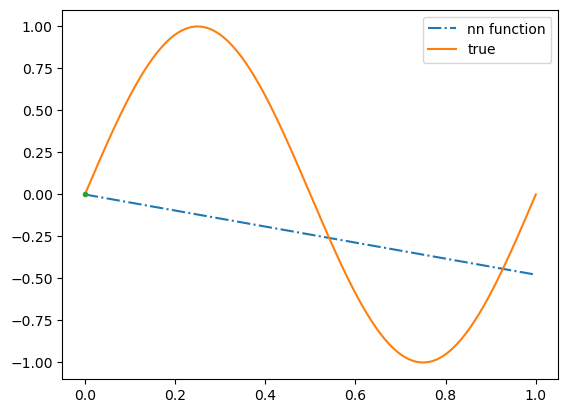

iteration:  2


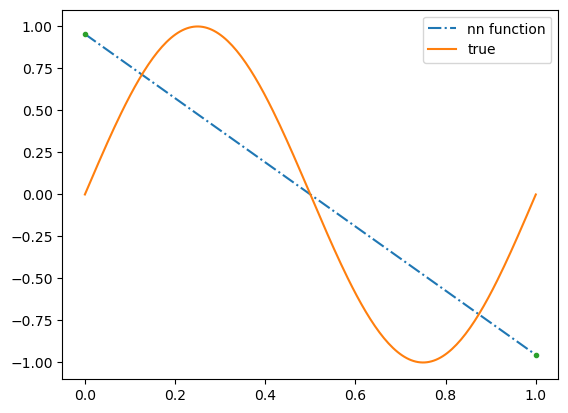

iteration:  3


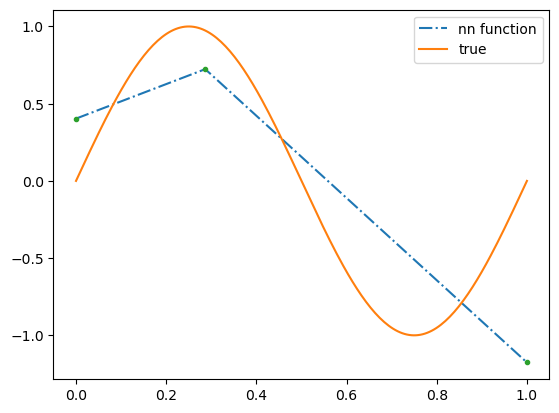

iteration:  4


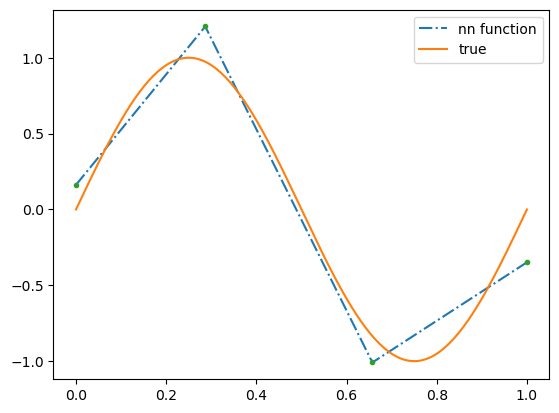

iteration:  5


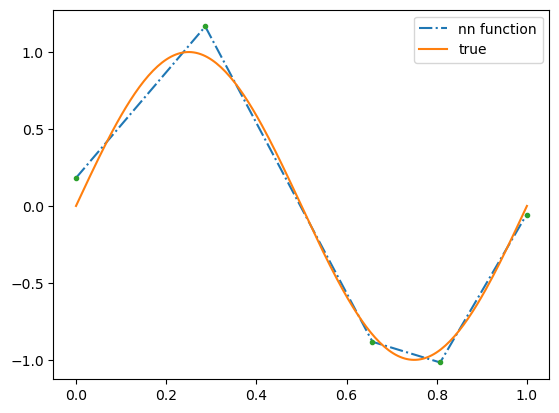

iteration:  6


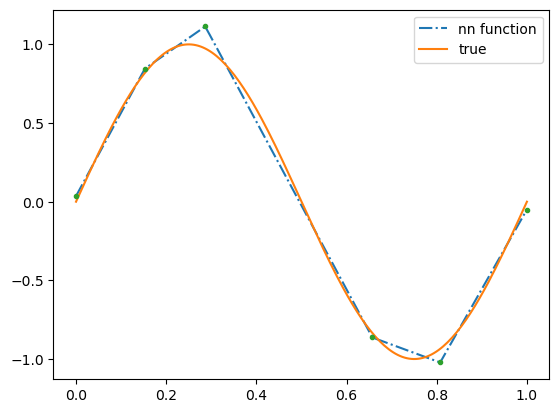

iteration:  7


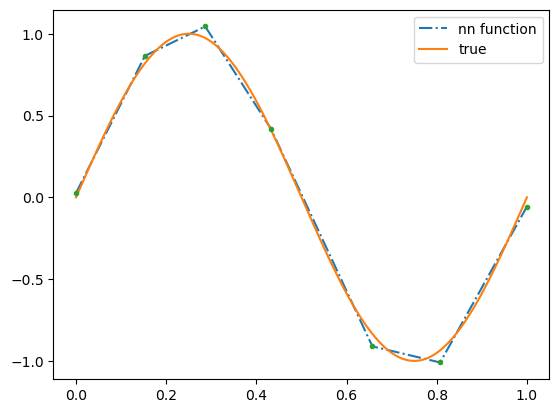

iteration:  8


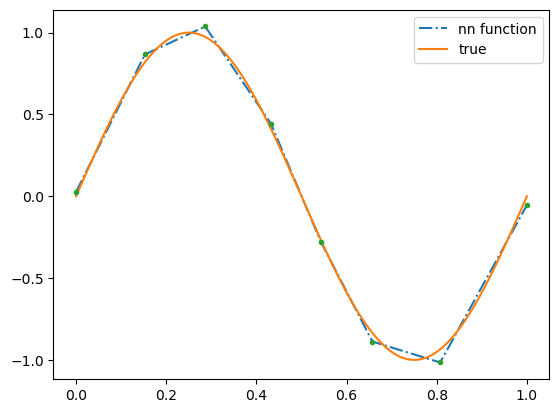

iteration:  9


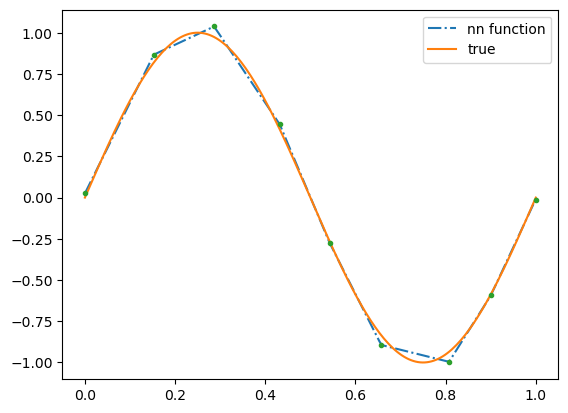

iteration:  10


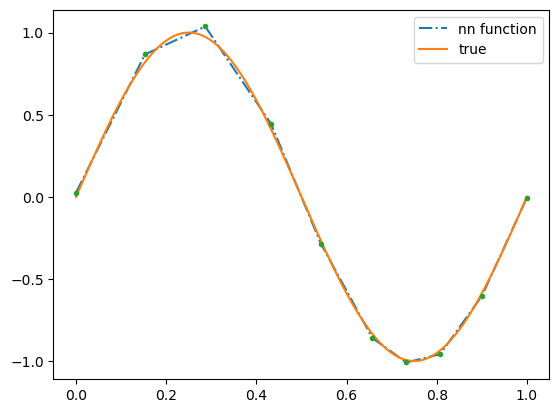

time taken:  1.27662992477417


In [3]:
## How OGA add neurons each time. Dynamics of OGA training.

def target(x):
    return torch.sin(2*pi*x) #+ 0.2*torch.sin(10*x)

N = 2**10 
# relu_dict_parameters = relu_dict(0,1,2**10) # 
# err_relu_list = [] 
my_model = None 
num_epochs = 10 #number of neurons added
err, my_model = OGAL2FittingReLU1D(my_model,target,N, \
                    num_epochs,plot_freq = 1,Nx = 1024,order =5,k = 1, solver = 'direct')



### Experiments


1. $f(x) = sin(x)$

2. $f(x) = sin(x) + 0.2*sin(10*x)$

using linear solver:  direct
iteration:  1
iteration:  2
iteration:  3
iteration:  4
iteration:  5
iteration:  6
iteration:  7
iteration:  8
iteration:  9
iteration:  10
iteration:  11
iteration:  12
iteration:  13
iteration:  14
iteration:  15
iteration:  16
iteration:  17
iteration:  18
iteration:  19
iteration:  20
iteration:  21
iteration:  22
iteration:  23
iteration:  24
iteration:  25
iteration:  26
iteration:  27
iteration:  28
iteration:  29
iteration:  30
iteration:  31
iteration:  32
iteration:  33
iteration:  34
iteration:  35
iteration:  36
iteration:  37
iteration:  38
iteration:  39
iteration:  40
iteration:  41
iteration:  42
iteration:  43
iteration:  44
iteration:  45
iteration:  46
iteration:  47
iteration:  48
iteration:  49
iteration:  50
iteration:  51
iteration:  52
iteration:  53
iteration:  54
iteration:  55
iteration:  56
iteration:  57
iteration:  58
iteration:  59
iteration:  60
iteration:  61
iteration:  62
iteration:  63
iteration:  64
iteration:  65
itera

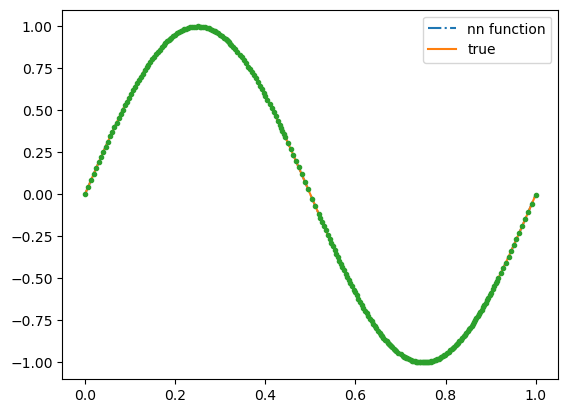

time taken:  5.471786022186279
neuron num 		 error 		 order
4 		 0.119943 		 *  

8 		 0.025024 		 2.260992 

16 		 0.005081 		 2.300135 

32 		 0.001255 		 2.017509 

64 		 0.000297 		 2.077907 

128 		 0.000071 		 2.058333 

256 		 0.000017 		 2.048030 



In [4]:
## How OGA add neurons each time. Dynamics of OGA training.

def target(x):
    return torch.sin(2*pi*x) #+ 0.2*torch.sin(10*x)

N = 2**10 
# relu_dict_parameters = relu_dict(0,1,2**10) # 
# err_relu_list = [] 
my_model = None 
exponent = 8 #2**8
# num_epochs = 10 # number of neurons added
for num_epochs in [2**exponent]: 
    err_l2, my_model = OGAL2FittingReLU1D(my_model,target,N, \
                    num_epochs,plot_freq = num_epochs,Nx = 1024,order =2,k = 1, solver = 'direct')

show_convergence_order(err_l2,exponent)

using linear solver:  direct
iteration:  1
iteration:  2
iteration:  3
iteration:  4
iteration:  5
iteration:  6
iteration:  7
iteration:  8
iteration:  9
iteration:  10
iteration:  11
iteration:  12
iteration:  13
iteration:  14
iteration:  15
iteration:  16
iteration:  17
iteration:  18
iteration:  19
iteration:  20
iteration:  21
iteration:  22
iteration:  23
iteration:  24
iteration:  25
iteration:  26
iteration:  27
iteration:  28
iteration:  29
iteration:  30
iteration:  31
iteration:  32
iteration:  33
iteration:  34
iteration:  35
iteration:  36
iteration:  37
iteration:  38
iteration:  39
iteration:  40
iteration:  41
iteration:  42
iteration:  43
iteration:  44
iteration:  45
iteration:  46
iteration:  47
iteration:  48
iteration:  49
iteration:  50
iteration:  51
iteration:  52
iteration:  53
iteration:  54
iteration:  55
iteration:  56
iteration:  57
iteration:  58
iteration:  59
iteration:  60
iteration:  61
iteration:  62
iteration:  63
iteration:  64
iteration:  65
itera

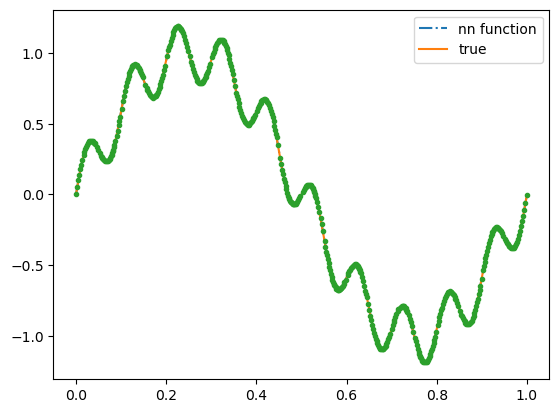

time taken:  139.29410314559937
neuron num 		 error 		 order
4 		 0.172691 		 *  

8 		 0.137602 		 0.327688 

16 		 0.096700 		 0.508921 

32 		 0.021635 		 2.160169 

64 		 0.006329 		 1.773356 

128 		 0.001319 		 2.262027 

256 		 0.000337 		 1.967164 

512 		 0.000086 		 1.974477 



In [6]:
def target(x):
    return torch.sin(2*pi*x) + 0.2*torch.sin(10*2*pi*x)

N = 2**11

my_model = None
exponent = 9
# num_epochs = 10 # number of neurons added
for num_epochs in [2**exponent]: 
    err_l2, my_model = OGAL2FittingReLU1D(my_model,target,N, \
                    num_epochs,plot_freq = num_epochs,Nx = 2048,order =3,k = 1, solver = 'direct')

show_convergence_order(err_l2,exponent)
# for i in [2,4,8,16,32,64,128,256]: 
#     print(err[i])